# Choosing a Sample Size for the Nonparametric Analysis
---
*Empirical investigations of how sample size affects the nonparametric analysis*

For more background, see the notebook [**Nonparametric Analysis**](../theory/nonparametric-analysis.ipynb) or our paper: [**Show Your Work with Confidence: Confidence Bands for Tuning Curves**](https://arxiv.org/abs/2311.09480).

In [1]:
# imports

import json
import warnings

from matplotlib import pyplot as plt
import numpy as np
from scipy import stats

from experiments import visualization
from opda import nonparametric
import opda.random

# constants

evaluations = {
    "matched": {
        "name": "MultiNLI-m",
    },
    "mismatched": {
        "name": "MultiNLI-mm",
    },
}

models = {
    "deberta-base": {
        "name": "DeBERTa",
        "style": {"linestyle": "-", "color": "#FFB000"},
    },
    "deberta-v3-base": {
        "name": "DeBERTaV3",
        "style": {"linestyle": "--", "color": "#648FFF"},
    },
}

confidences = {
    0.01: {"style": {"marker": "D", "color": "tab:gray"  }},
    0.05: {"style": {"marker": "o", "color": "tab:blue"  }},
    0.10: {"style": {"marker": "P", "color": "tab:orange"}},
    0.25: {"style": {"marker": "X", "color": "tab:green" }},
    0.50: {"style": {"marker": "*", "color": "tab:red"   }},
    0.75: {"style": {"marker": "s", "color": "tab:purple"}},
    0.90: {"style": {"marker": "v", "color": "tab:brown" }},
    0.95: {"style": {"marker": "^", "color": "tab:pink"  }},
    0.99: {"style": {"marker": "p", "color": "tab:cyan"  }},
}


# experimental settings

evaluation = "matched"
model = "deberta-v3-base"
band = "ld_highest_density"

sample_sizes = [6, 20, 34, 48]
n = sample_sizes[-1]  # Later analyses assume n == sample_sizes[-1]
ns_grid = np.linspace(1, n, num=10_000)

y_min = 0.
y_max = 1.

confidence = 0.80


# Configure environment.

generator = np.random.RandomState(0)
opda.random.set_seed(generator)

warnings.filterwarnings("ignore")


# Configure Matplotlib.

plt.style.use("experiments.default")

## Power Analysis and the Design of Experiments

One of the most important decisions in any experiment is the sample size. For optimal design analysis that means the number of hyperparameter search iterations. If the experiment has too few, then it'll fail to provide a useful conclusion. On the other hand, running too many wastes resources. What's more, if we collect iterations until the confidence bands give a useful conclusion, then we lose our statistical guarantees due to the optional stopping problem [(Yu et al., 2014)](https://doi.org/10.3758/s13423-013-0495-z). Thus, we'd like to know, a priori, what sample size is necessary.

In statistics, this exercise is usually called a *power analysis*. While we won't develop a formal power analysis here, we'll empirically investigate how sample size affects the confidence bands in order to develop some useful intuitions. These explorations will culminate in an empirical rule of thumb that gives the minimum sample size.

For these explorations, we'll use data from fine-tuning DeBERTa and DeBERTaV3 on MultiNLI. For details on the models, dataset, or hyperparameter search space, see the notebook: [Evaluating DeBERTaV3 with the Nonparametric Analysis](./evaluating-debertav3-with-the-nonparametric-analysis.ipynb).

In [2]:
# load the data
model_to_evaluation_to_ys = {}
for model_ in models:
    for evaluation_ in evaluations:
        ys = []
        with open(f"../../data/deberta/{model_}.results.jsonl") as f_in:
            for ln in f_in:
                ex = json.loads(ln)
                ys.append(max(
                    score
                    for _, score in ex["learning_curves"][evaluation_]
                ))
        if model_ not in model_to_evaluation_to_ys:
            model_to_evaluation_to_ys[model_] = {}
        model_to_evaluation_to_ys[model_][evaluation_] = np.array(ys)

total_samples = 1_024
for model_ in models:
    for evaluation_ in evaluations:
        if len(model_to_evaluation_to_ys[model_][evaluation_]) != total_samples:
            raise RuntimeError(
                "The experiment data does not contain the correct"
                " number of examples.",
            )

## How Does Sample Size Affect the Confidence Bands?

Let's build some intuition for how the confidence bands change as we increase the sample size. First, we'll plot the confidence bands for various sample sizes, and second we'll plot where the confidence band becomes trivial (the upper bound on the support) against the total sample size.

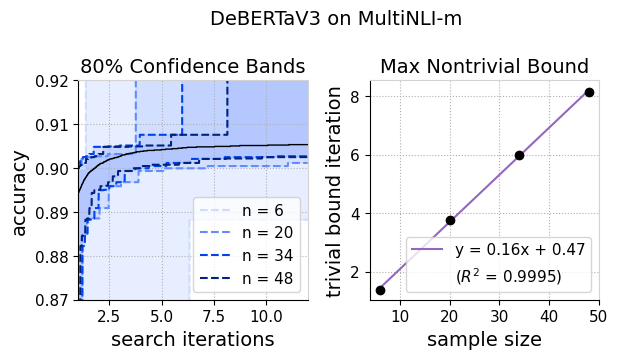

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6.25, 3.65))

# Plot the confidence bands for various sample sizes.
ys = generator.choice(
    model_to_evaluation_to_ys[model][evaluation],
    size=n,
    replace=False,
)
for sample_size_ in sample_sizes:
    # Construct the confidence bands.
    lower_cdf, _, upper_cdf =\
        nonparametric.EmpiricalDistribution.confidence_bands(
            ys[:sample_size_],
            confidence=confidence,
            a=y_min,
            b=y_max,
            method=band,
        )

    # Plot the confidence bands.
    color = visualization.color_with_lightness(
        c=models[model]["style"]["color"],
        lightness=0.75 * (1 - sample_size_ / n) + 0.25,
    )

    axes[0].plot(
        ns_grid,
        lower_cdf.quantile_tuning_curve(ns_grid),
        label=f"n = {sample_size_}",
        **{**models[model]["style"], "color": color},
    )
    axes[0].plot(
        ns_grid,
        upper_cdf.quantile_tuning_curve(ns_grid),
        **{**models[model]["style"], "color": color},
    )
    axes[0].fill_between(
        ns_grid,
        upper_cdf.quantile_tuning_curve(ns_grid),
        lower_cdf.quantile_tuning_curve(ns_grid),
        alpha=0.15,
        color=models[model]["style"]["color"],
    )

# Plot our best estimate of the ground truth.
point_cdf = nonparametric.EmpiricalDistribution(
    model_to_evaluation_to_ys[model][evaluation],
    a=y_min,
    b=y_max,
)

axes[0].plot(
    ns_grid,
    point_cdf.quantile_tuning_curve(ns_grid),
    linewidth=1,
    linestyle="-",
    color="k",
)

# Format the plot.
axes[0].set_xlim(1, n // 4)
axes[0].set_ylim(0.87, 0.92)
axes[0].spines["right"].set_color("lightgrey")
axes[0].spines["top"].set_color("lightgrey")
axes[0].legend(loc="lower right")
axes[0].set_xlabel("search iterations")
axes[0].set_ylabel("accuracy")
axes[0].set_title(
    f"{confidence * 100:.0f}% Confidence Bands",
)

# Plot the trivial bound iteration vs. the sample size.
trivial_bound_iterations = []
for sample_size_ in sample_sizes:
    ys = generator.choice(
        model_to_evaluation_to_ys[model][evaluation],
        size=sample_size_,
        replace=False,
    )

    lower_cdf, _, _ =\
        nonparametric.EmpiricalDistribution.confidence_bands(
            ys,
            confidence=confidence,
            a=y_min,
            b=y_max,
            method=band,
        )

    trivial_bound_iterations.append(
        ns_grid[np.argmax(lower_cdf.quantile_tuning_curve(ns_grid))],
    )

# Fit a linear regression to the sample size/trivial bound iteration data.
regression = stats.linregress(sample_sizes, trivial_bound_iterations)

axes[1].scatter(
    sample_sizes,
    trivial_bound_iterations,
    color="k",
    zorder=10,
)
axes[1].plot(
    sample_sizes,
    [
        regression.slope * sample_size_ + regression.intercept
        for sample_size_ in sample_sizes
    ],
    color="tab:purple",
    label=f"y = {regression.slope:.2f}x + {regression.intercept:.2f}",
)
axes[1].plot(
    [],
    [],
    " ",
    label=rf"($R^2$ = {regression.rvalue**2:.4f})",
)

# Format the plot.
axes[1].spines["right"].set_color("lightgrey")
axes[1].spines["top"].set_color("lightgrey")
axes[1].legend(loc="lower right")
axes[1].set_xlabel("sample size")
axes[1].set_ylabel("trivial bound iteration")
axes[1].set_title("Max Nontrivial Bound")

fig.suptitle(
    f'{models[model]["name"]} on {evaluations[evaluation]["name"]}',
    x=0.55,
)

fig.tight_layout()

plt.show()

On the right, we see where the upper confidence band becomes trivial (i.e., jumps to the upper bound) seems evenly spaced as we linearly increase the sample size. That observation suggests that there's a linear relationship between the sample size and where the upper bound becomes trivial. The plot on the right confirms this hypothesis, revealing a nearly perfect linear relationship with 99.95% of the variance explained.

## How Does the Trivial Bound Iteration Depend on the Confidence?

We've seen that for 80% confidence, there's a strong linear relationship between the sample size and the trivial bound search iteration. In general, this relationship depends on the confidence level. Let's plot this relationship for different confidence levels as well as different models:

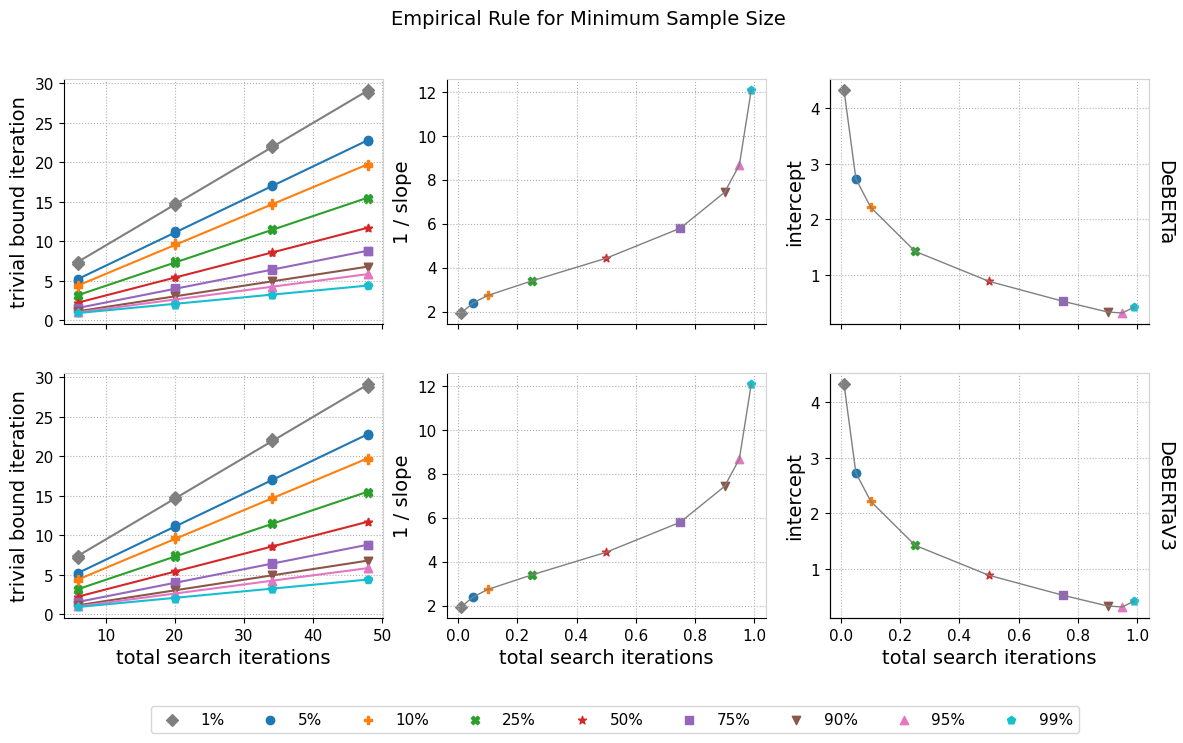

In [4]:
# Compute the linear relationships between the total number of search
# iterations and the trivial bound iteration.
model_to_confidence_to_results = {model_: {} for model_ in models}
for model_ in models:
    for confidence_ in confidences:
        trivial_bound_locations = []
        for sample_size_ in sample_sizes:
            ys = generator.choice(
                model_to_evaluation_to_ys[model][evaluation],
                size=sample_size_,
                replace=False,
            )

            lower_cdf, _, _ =\
                nonparametric.EmpiricalDistribution.confidence_bands(
                    ys,
                    confidence=confidence_,
                    a=y_min,
                    b=y_max,
                    method=band,
                )

            trivial_bound_locations.append(
                ns_grid[np.argmax(lower_cdf.quantile_tuning_curve(ns_grid))],
            )

        regression = stats.linregress(sample_sizes, trivial_bound_locations)

        model_to_confidence_to_results[model_][confidence_] = (
            regression, trivial_bound_locations,
        )

# Plot the linear relationships and how their parameters change.
fig, axes = plt.subplots(
    nrows=len(models),
    ncols=3,
    sharex="col",
    sharey="col",
    figsize=(14, 7),
)
for i, model_ in enumerate(models):
    for confidence_ in confidences:
        regression, trivial_bound_locations =\
            model_to_confidence_to_results[model_][confidence_]

        # Plot the linear relationships.
        axes[i, 0].scatter(
            sample_sizes,
            trivial_bound_locations,
            label=f"{confidence_ * 100:.0f}%",
            **confidences[confidence_]["style"],
        )
        axes[i, 0].plot(
            sample_sizes,
            [
                regression.slope * sample_size_ + regression.intercept
                for sample_size_ in sample_sizes
            ],
            **confidences[confidence_]["style"],
        )

        # NOTE: In order to apply separate styles to each point, separately plot
        # each point for the 1/slope and intercept vs. total search iterations
        # relationships.

        # Plot 1/slope vs. total search iterations.
        axes[i, 1].scatter(
            [confidence_],
            [1/regression.slope],
            **confidences[confidence_]["style"],
        )
        # Plot intercept vs. total search iterations.
        axes[i, 2].scatter(
            [confidence_],
            [regression.intercept],
            **confidences[confidence_]["style"],
        )

    # Add a line connecting the points in the 1/slope vs. total search
    # iterations plot.
    axes[i, 1].plot(
        *zip(*[
            (confidence_, 1/regression.slope)
            for confidence_, (regression, _)
            in model_to_confidence_to_results[model_].items()
        ]),
        color="grey",
        linewidth=1,
    )
    # Add a line connecting the points in the intercept vs. total search
    # iterations plot.
    axes[i, 2].plot(
        *zip(*[
            (confidence_, regression.intercept)
            for confidence_, (regression, _)
            in model_to_confidence_to_results[model_].items()
        ]),
        color="grey",
        linewidth=1,
    )

# Format the plot.
for i, model_ in enumerate(models):
    axes[i, 0].set_ylabel("trivial bound iteration")
    axes[i, 1].set_ylabel("1 / slope")
    axes[i, 2].set_ylabel("intercept")

    yaxis2 = axes[i, -1].twinx()
    yaxis2.set_yticks([])
    yaxis2.spines["right"].set_color("lightgrey")
    yaxis2.spines["top"].set_color("lightgrey")
    yaxis2.set_ylabel(models[model_]["name"], labelpad=18, rotation=270)

for j in range(3):
    axes[len(models)-1, j].set_xlabel("total search iterations")

for i in range(len(models)):
    for j in range(3):
        axes[i, j].spines["right"].set_color("lightgrey")
        axes[i, j].spines["top"].set_color("lightgrey")

axes[1, 0].legend(
    loc="lower left",
    bbox_to_anchor=(0.25, -0.5),
    ncol=len(confidences),
)

fig.suptitle("Empirical Rule for Minimum Sample Size")

plt.show()

The relationships are affected by the confidence level but not the model. In fact, the relationship will look exactly the same for all models because the vertical distance between the confidence bands at the order statistics, and thus the iteration at which the bound becomes trivial, doesn't depend on the data. It does depend on the confidence level; however, we see that for all confidence levels the relationship is well-approximated by a linear function. As the confidence level increases, the intercepts of these lines approach zero and the reciprocals of the slopes increase. Thus, as one would expect, higher levels of confidence require a greater multiple of search iterations to get an effective bound.